In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from utils import display_pca_scatterplot, grid_search
import json
import pandas as pd
import random
from sklearn.metrics import f1_score
from spacy.tokenizer import Tokenizer
from spacy.lang.tr import Turkish
import numpy as np
import warnings
from tqdm import tqdm

In [2]:
nlp = Turkish()
stn_path = '../Other Data/SentiTurkNet/STN.xlsx'
train_path = '../Boun Twitter Data/train.json'
val_path = '../Boun Twitter Data/validation.json'
test_path = '../Boun Twitter Data/test.json'

In [3]:
#SentiTurkNet: Includes positive negative values of Turkish words
#Check out this for more information: http://myweb.sabanciuniv.edu/rdehkharghani/sentiturknet-3/
stn = pd.read_excel(stn_path)

stn = stn.drop_duplicates(['synonyms']).set_index('synonyms')
final_stn = {}
for words in stn.index:
    if words is np.nan:
        continue
    for word in words.split(','):
        final_stn[word.strip()] = {'pos':stn.loc[words]['pos value'],'neg':stn.loc[words]['neg value']}

In [4]:
def feature_extraction(text):
    pos_val = 0
    neg_val = 0 
    for token in nlp(text):#splitting sentence into words by nlp(text)
        word = token.text.lower()
        if word in final_stn:
            pos_val+=final_stn[word]['pos']
            neg_val+=final_stn[word]['neg']
    return [pos_val, neg_val]

In [5]:
with open(train_path, 'r') as f:
    train = json.load(f)
with open(val_path, 'r') as f:
    val = json.load(f)
with open(test_path, 'r') as f:
    test = json.load(f)

train = train+val

In [6]:
mapping = {'negative':0, 'neutral':1, 'positive':2}
X_train = []
y_train = []
X_test = []
y_test = []
for element in tqdm(train):
    X_train.append(feature_extraction(element['sentence']))
    y_train.append(mapping[element['value']])
for element in tqdm(test):
    X_test.append(feature_extraction(element['sentence']))
    y_test.append(mapping[element['value']])

100%|██████████| 1592/1592 [00:00<00:00, 5595.63it/s]


## Visualization of Sentence Vectors

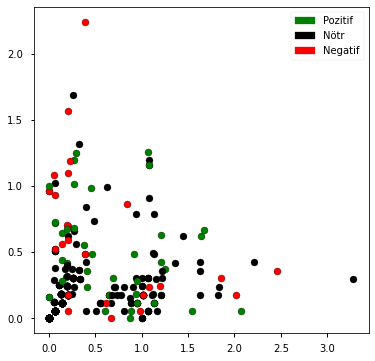

In [9]:
display_pca_scatterplot(X_train, y_train, 500)

## Training a Model with Grid Search

In [10]:
tuned_parameters = {
    'hidden_layer_sizes': [(50,100,50)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.00001],
    'learning_rate': ['constant','adaptive'],
}

model = MLPClassifier(max_iter=1000)
clf = grid_search(tuned_parameters, model, X_train, y_train, X_test, y_test, score='recall_macro')

# Tuning hyper-parameters for recall_macro

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    3.7s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    4.3s finished


Best parameters set found on development set:
{'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
Grid scores on development set:
0.335 (+/-0.003) for {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.347 (+/-0.006) for {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.334 (+/-0.001) for {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.347 (+/-0.004) for {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0       0.39      0.06  